In [2]:
import stan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run before Stan
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Build Stochastic Volatility Model

In [3]:
####################### Build Stochastic Volatility Model
model_code = """
data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
}
parameters {
  real mu;                     // mean log volatility
  real<lower=-1, upper=1> phi; // persistence of volatility
  real<lower=0> sigma;         // white noise shock scale
  vector[T] h;                 // log volatility at time t
}
model {
  phi ~ uniform(-1, 1);
  sigma ~ cauchy(0, 5);
  mu ~ cauchy(0, 10);
  h[1] ~ normal(mu, sigma / sqrt(1 - phi * phi));
  for (t in 2:T) {
    h[t] ~ normal(mu + phi * (h[t - 1] -  mu), sigma);
  }
  for (t in 1:T) {
    y[t] ~ normal(0, exp(h[t] / 2));
  }
}
"""

# Build Particle Filtering

In [4]:
####################### Build Particle Filtering
from scipy.stats import norm

def particle_filter(y, mu, phi, sigma, N=1000):
    T = len(y)
    log_weights = np.zeros(N)
    particles = np.zeros((T, N))

    # Initialize particles
    particles[0, :] = norm.rvs(loc=mu, scale=sigma / np.sqrt(1 - phi**2), size=N)

    for t in range(1, T):
        # Propagate
        particles[t, :] = mu + phi * (particles[t - 1, :] - mu) + norm.rvs(scale=sigma, size=N)

        # Update weights
        log_weights = -0.5 * (y[t]**2 / np.exp(particles[t, :])) - 0.5 * particles[t, :] - 0.5 * np.log(2 * np.pi)
        log_weights = log_weights - np.max(log_weights)
        weights = np.exp(log_weights)
        weights /= np.sum(weights)

        # Resampling
        idx = np.random.choice(np.arange(N), size=N, p=weights, replace=True)
        particles[t, :] = particles[t, idx]

    return particles


# Build Predicted Volatility

In [17]:
####################### Build Predicted Volatility
def predict_volatility(mu, phi, sigma, initial_volatility, steps=1):
    predicted_volatilities = np.zeros(steps)
    predicted_volatilities[0] = mu + phi * (initial_volatility - mu) + norm.rvs(scale=sigma).item()
    
    for t in range(1, steps):
        predicted_volatilities[t] = mu + phi * (predicted_volatilities[t - 1] - mu) + norm.rvs(scale=sigma).item()
    
    return predicted_volatilities



# Define the function to fit the SV model and perform predictions

In [20]:
# Define the function to fit the SV model and perform predictions
def fit_and_predict_sv(train_data, window_size):
    T = len(train_data)
    data = {'y': train_data.values, 'T': T}

    stan_model = stan.build(model_code, data=data)

    fit = stan_model.sample(num_chains=2, num_samples=500) #500 for the 1st model

    # Retrieve posterior samples
    posterior_samples = fit.to_frame()
    mu_samples = posterior_samples['mu'].values
    phi_samples = posterior_samples['phi'].values
    sigma_samples = posterior_samples['sigma'].values

    # Perform particle filtering with posterior samples
    N = 100  # change to 1000 in the future
    particles = np.zeros((len(train_data), N, len(mu_samples)))

    for i, (mu, phi, sigma) in enumerate(zip(mu_samples, phi_samples, sigma_samples)):
        particles[:, :, i] = particle_filter(train_data.values, mu, phi, sigma, N=N)

    # Calculate filtered volatilities
    filtered_volatilities = np.mean(particles, axis=1)

    # Convert log-volatility to volatility
    volatility_from_filtered_volatilities = np.exp(filtered_volatilities / 2)

    # Use the last value of the training data as the initial_volatility
    initial_volatility = np.mean(filtered_volatilities[-1])

    # Predict future volatilities for each posterior sample
    future_volatilities = np.zeros((1, len(mu_samples)))

    for i, (mu, phi, sigma) in enumerate(zip(mu_samples, phi_samples, sigma_samples)):
        future_volatilities[:, i] = predict_volatility(mu, phi, sigma, initial_volatility)

    # Calculate the mean and standard deviation of future volatilities
    # mean_future_volatilities = np.mean(future_volatilities, axis=1)
    # std_future_volatilities = np.std(future_volatilities, axis=1)

    # Convert log-volatility to volatility
    future_volatilities_exp = np.exp(future_volatilities / 2)

    # Calculate the mean and standard deviation of future volatilities
    mean_future_volatilities_exp = np.mean(future_volatilities_exp, axis=1)
    std_future_volatilities_exp = np.std(future_volatilities_exp, axis=1)

    return mean_future_volatilities_exp


# Import Data

In [7]:
import os
import datetime as dt

main_path = os.getcwd()

#load price (exchange rate) data
df_P = pd.read_pickle(main_path+'/data/future_price_use.pkl')
df_P = df_P.fillna(method='ffill').drop(df_P.index[0])

#weekly return
df_r = pd.read_pickle(main_path+'/data/future_return_use.pkl')
df_r = df_r.fillna(method='ffill').dropna()
df_r = df_r.drop(columns='ZT')
df_r = df_r.drop(columns='ZF')
df_r

,GC,ZC,HE,CT,YM,NG
Date,,,,,,
2018-05-07,0.004799,-0.022571,-0.026463,-0.020035,0.024558,0.035042
2018-05-14,-0.021835,0.032713,0.143951,0.022808,-0.004109,0.014612
2018-05-21,0.010154,0.008696,-0.006693,0.030734,0.000364,0.032315
2018-05-28,-0.006522,-0.035714,0.045822,0.045847,-0.004084,0.007826
2018-06-04,0.002549,-0.035121,0.029317,0.017578,0.027529,-0.024308
...,...,...,...,...,...,...
2023-03-27,-0.006609,0.027216,-0.024943,0.081526,0.031633,0.000000
2023-04-03,0.021788,-0.025738,-0.014618,0.005074,0.005947,-0.092509
2023-04-10,-0.004821,0.035354,-0.032367,-0.004086,0.011230,0.051218


# Prediction

In [22]:
# Array of asset names
assets = list(df_r.columns)

# Create an empty DataFrame to store SV model predictions
sv_preds = pd.DataFrame(columns=df_r.columns)

window_size = 105
n_preds = df_r.shape[0] - window_size + 1

# Iterate through the dataset with the sliding window method
for i in range(n_preds):
    train_data = df_r.iloc[i:i + window_size]

    # Predict asset return for one step
    for a in assets:
        # Fit SV model and predict future volatilities
        mean_future_volatility_exp = fit_and_predict_sv(train_data[a], window_size)

        # Generate future return for the asset
        future_return = norm.rvs(scale=mean_future_volatility_exp)

        # Save the prediction to the sv_preds DataFrame
        t = train_data.index[-1]
        sv_preds.loc[t, a] = future_return


Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
Buildi

Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampl

Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling

Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampli

  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfro

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.


Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampli

Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), d

Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per trans

  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: fo

Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sa

Sampling:  33% (1000/3000)
Sampling:  43% (1300/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Samp

Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per trans

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000

Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling

Sampling:  50% (1500/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampli

  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition woul

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampli

Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampli

Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Samp

Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Samp

Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sam

Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.

Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10

Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampl

Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sam

Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  63% (1900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Samp

Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampli

Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampli

Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  63% (1901/3000)
Sampling:  83% (2501/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampl

Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampl

  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations acc

  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Grad

Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done

  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation 

  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitio

  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapf

  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition wo

  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accord

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.


Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1

Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Samplin

Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampl

Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampli

Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampli

  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition woul

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adju

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampl

Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampl

Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampl

Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:

Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  67% (2000/3000)
Sampling: 100% (3000/3000)
Sampli

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Samplin

Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampli

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition woul

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/300

Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sam

Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Samp

Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sa

Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampli

Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Samp

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3

Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Samp

Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sam

Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Samp

  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  A

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/30

Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampli

Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), 

Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluat

Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Samplin

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Samp

Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Samp

Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (201/3000)
Sampl

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Samp

Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  67% (2000/3000)
Sampling:  87% (2600/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during

Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling

Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 

Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient ev

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:  10% (301/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000

  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  63% (1900/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take

Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling

Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling: 

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampl

Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling

Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Samplin

Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampl

Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampli

  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 4.5e-0

Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in c

Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Samp

Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfr

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/300

Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  60% (1800/3000)
Sampl

Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1401/3000)
Sampling:  53% (1601/3000)
Sampling:  57% (1700/3000)
Sampling:  63% (1900/3000)
Sampl

Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done

Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  67% (2000/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Mes

Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  63% (1900/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sam

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sam

Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 secon

  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messag

Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  40%

  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
 

Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling

Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 

Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling: 

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adj

Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Samp

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your exp

Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received duri

Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received durin

Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  50% (1500/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  4

Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sam

  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Grad

Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling

  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1401/3000)
Sampling:  57% (1701/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition woul

Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  63% (1900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:

Messages received during sampling:
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  70% (2100/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation to

Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling

Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 

Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:

Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  50% (1500/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per tran

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/300

  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: fo

  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Ad

Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampli

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/30

Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling:  83% (2501/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Samp

  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  70% (2100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations ac

Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampl

  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations ac

Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  53% (1600/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampl

  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   

Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds

Sampling:  10% (301/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:

  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sam

Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampli

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampli

Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sam

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/30

Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  17% (500/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  37% (1100/3000)
Sampling:  43% (1300/3000)
Sampling:  50% (1500/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  80% (2400/3000)
Samp

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (200/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  80% (2400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1

Sampling:  40% (1200/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:  10% (300/3000)
Sampling:  20% (600/3000)
Sampling:  30% (900/3000)
Sampling:  40% (1200/3000)
Sampling:  50% (1500/3000)
Sampling:  77% (2300/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient ev

  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   7% (201/3000)
Sampling:  13% (400/3000)
Sampling:  20% (600/3000)
Sampling:  27% (800/3000)
Sampling:  37% (1100/3000)
Sampling:  47% (1400/3000)
Sampling:  73% (2200/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   

In [25]:
sv_preds

,GC,ZC,HE,CT,YM,NG
2020-05-04,0.022069,0.036626,0.072188,-0.015968,-0.01683,0.002648
2020-05-11,-0.009607,0.022653,-0.179128,0.011984,-0.002509,-0.008763
2020-05-18,-0.012643,-0.004186,-0.080903,-0.010259,-0.026397,-0.049784
2020-05-25,-0.013883,-0.015463,0.136159,0.049197,-0.026872,0.018277
2020-06-01,-0.040497,-0.008197,0.073749,0.006404,0.031045,-0.018452
...,...,...,...,...,...,...
2023-03-27,0.005634,0.011927,0.007047,0.013373,-0.031732,-0.045529
2023-04-03,-0.001144,-0.033299,0.056311,-0.026316,-0.048009,0.049059
2023-04-10,0.021218,0.032572,0.026543,0.033794,-0.010958,-0.04387
2023-04-17,-0.02809,0.011018,-0.040963,0.045972,0.012572,-0.024544


In [30]:
sv_preds.head(20)

,GC,ZC,HE,CT,YM,NG
2020-05-04,0.022069,0.036626,0.072188,-0.015968,-0.01683,0.002648
2020-05-11,-0.009607,0.022653,-0.179128,0.011984,-0.002509,-0.008763
2020-05-18,-0.012643,-0.004186,-0.080903,-0.010259,-0.026397,-0.049784
2020-05-25,-0.013883,-0.015463,0.136159,0.049197,-0.026872,0.018277
2020-06-01,-0.040497,-0.008197,0.073749,0.006404,0.031045,-0.018452
2020-06-08,-0.003593,-0.013128,-0.069496,0.016211,0.001193,-0.009397
2020-06-15,0.007275,-0.030935,0.034451,0.013958,-0.051254,0.044868
2020-06-22,-0.015838,-0.021368,-0.0213,0.029388,-0.031082,0.014145
2020-06-29,0.032142,0.049365,-0.038217,-0.006123,0.009338,0.047689
2020-07-06,0.002682,-0.039658,-0.064482,0.009387,-0.002262,-0.087022


In [24]:
# Save predictions
folder_path = main_path+'/data'
file_path = os.path.join(folder_path, 'jason_preds_fit_sv_pf.pkl')
sv_preds.to_pickle(file_path)

In [34]:
# Calculate cumulative returns
cumulative_returns = (1 + sv_preds).cumprod()

# If you have an initial asset value, multiply it by the cumulative returns
initial_asset_value = 1  # Replace this with your initial asset value
cumulative_asset_value = initial_asset_value * cumulative_returns
cumulative_asset_value

,GC,ZC,HE,CT,YM,NG
2020-05-04,1.022069,1.036626,1.072188,0.984032,0.98317,1.002648
2020-05-11,1.01225,1.060108,0.88013,0.995825,0.980703,0.993862
2020-05-18,0.999452,1.05567,0.808924,0.985609,0.954815,0.944383
2020-05-25,0.985577,1.039347,0.919067,1.034097,0.929157,0.961644
2020-06-01,0.945664,1.030827,0.986847,1.040719,0.958003,0.9439
...,...,...,...,...,...,...
2023-03-27,0.991347,0.874457,0.204192,1.400828,0.807557,1.06603
2023-04-03,0.990213,0.845339,0.215691,1.363965,0.768786,1.118329
2023-04-10,1.011223,0.872873,0.221416,1.410059,0.760362,1.069268
2023-04-17,0.982818,0.88249,0.212346,1.474881,0.769922,1.043023


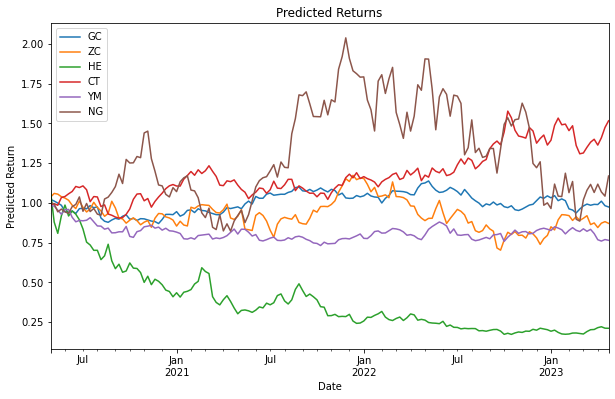

In [35]:
# Calculate cumulative returns
cumulative_returns = (1 + sv_preds).cumprod()

# If you have an initial asset value, multiply it by the cumulative returns
initial_asset_value = 1  # Replace this with your initial asset value
cumulative_asset_value = initial_asset_value * cumulative_returns
cumulative_asset_value

# Plot the cumulative returns
fig, ax = plt.subplots(figsize=(10, 6))
cumulative_asset_value.plot(ax=ax)

ax.set_title("Predicted Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Predicted Return")
ax.legend(loc="upper left")

plt.show()

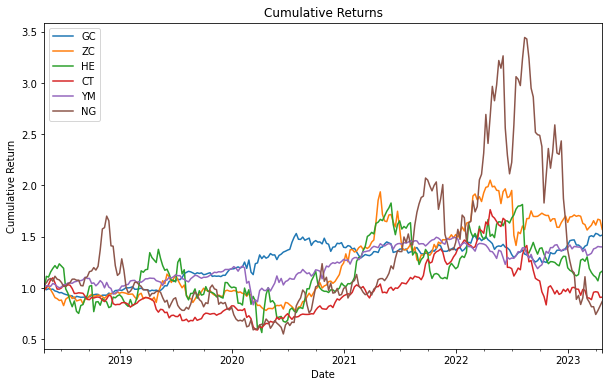

In [32]:
##### Original Return
# Calculate cumulative growth factors from the return data
cumulative_growth_factors = 1 + df_r

# Calculate cumulative product for each asset
cumulative_returns = cumulative_growth_factors.cumprod()

# Plot the cumulative returns
fig, ax = plt.subplots(figsize=(10, 6))
cumulative_returns.plot(ax=ax)

ax.set_title("Cumulative Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.legend(loc="upper left")

plt.show()

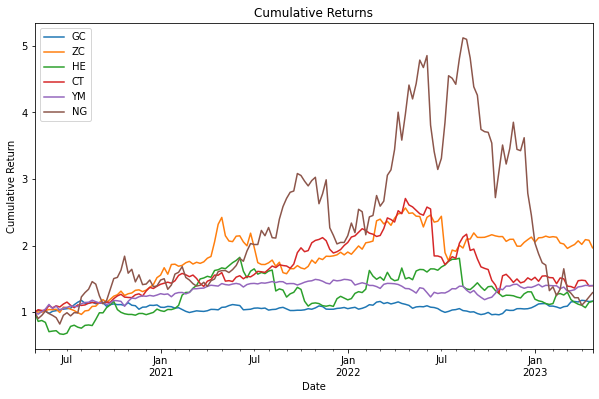

In [36]:
# From 105 datapoint

# Calculate cumulative growth factors from the return data
cumulative_growth_factors = 1 + df_r

# Set the first 105 rows to 1
cumulative_growth_factors.iloc[:105, :] = 1

# Calculate cumulative product for each asset
cumulative_returns = cumulative_growth_factors.cumprod()

# Plot the cumulative returns starting from the 105th data point
fig, ax = plt.subplots(figsize=(10, 6))
cumulative_returns.iloc[104:].plot(ax=ax)

ax.set_title("Cumulative Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.legend(loc="upper left")

plt.show()


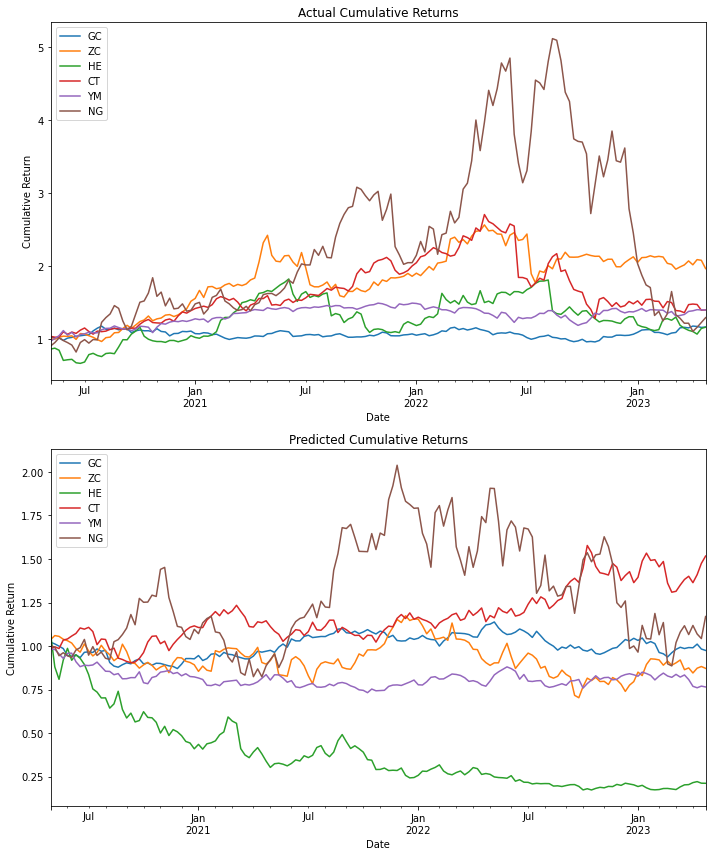

In [46]:
import matplotlib.pyplot as plt

# Calculate cumulative returns for the predictions
cumulative_returns_pred = (1 + sv_preds).cumprod()

# Calculate cumulative growth factors from the actual return data
cumulative_growth_factors = 1 + df_r
cumulative_growth_factors.iloc[:105, :] = 1

# Calculate cumulative product for each asset
cumulative_returns_actual = cumulative_growth_factors.cumprod()

# Create a 2x1 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot the actual cumulative returns
cumulative_returns_actual.iloc[105:].plot(ax=axes[0])
axes[0].set_title("Actual Cumulative Returns")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend(loc="upper left")

# Plot the predicted cumulative returns
cumulative_returns_pred.plot(ax=axes[1])
axes[1].set_title("Predicted Cumulative Returns")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative Return")
axes[1].legend(loc="upper left")

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()
